# Plotting

Contains utility functions related to plotting.  The functions here make it easy to plot multiple images.  To facilitate this they take care of changing the channels from CHW to HWC (if required), removing axes where not needed, managing the image size and number of images per row, assign titles to images and manage kwargs

Return the plot as a matplotlib axis

In [ ]:
#| default_exp plotting

In [ ]:
#| export
from __future__ import annotations
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from datasets import load_dataset,load_dataset_builder
from matplotlib.pyplot import axes as ax

from typing import List

/Users/johnrichmond/miniconda/envs/miniai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from miniai.datasets import inplace, collate_dict

In [ ]:
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

## Plotting

### Single Images 

In [ ]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(img, ax=None, title=None, noframe=True, figsize=None, **kwargs):
    # prepare images.  Check if pytorch tensor by using attributes
    if fc.hasattrs(img, ('cpu', 'permute', 'detach')):
        img = img.detach().cpu()
        if len(img.shape)==3 and img.shape[0]<8:
            img = img.permute(1,2,0)
        elif not isinstance(img, np.ndarray):
            img = np.asarray(img)
    # If only one channel remove the dimension
    if img.shape[-1] == 1:
        img = img[...,0]
    # if axes do not exist then create them
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    # plot the array
    ax.imshow(img, **kwargs)
    # Add a title
    if title is not None: ax.set_title(title)
    # turn off tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    # Finally set whether or not to show a frame
    if noframe:
        ax.axis('off')
    return ax

Note that the fastcore library gives a list of all of the parameters that can be passed as kwargs, for example interpolation.|

In [ ]:
help(show_image)

Help on function show_image in module __main__:

show_image(img, ax=None, title=None, noframe=True, figsize=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    #|export



#### Load the Fashion Mnist dataset to provide some example images

In [ ]:
ds_loader = load_dataset("fashion_mnist")
train_ds, test_ds = ds_loader['train'], ds_loader['test']

Found cached dataset fashion_mnist (/Users/johnrichmond/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 333.66it/s]


In [ ]:
train_ds.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
labels = train_ds.features['label']
labels.int2str(0)

'T - shirt / top'

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
@inplace
def transformi(b, key:str='image'): b[key] = [TF.to_tensor(o) for o in b[key]]

In [ ]:
tsds = train_ds.with_transform(transformi)

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
dl=DataLoader(tsds, collate_fn=collate_dict(tsds), batch_size=16)

In [ ]:
xb, yb = next(iter(dl))

In [ ]:
xb.shape, yb.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

To plot the image using matplotlib imshow requires the image to be indexed down to just the last two dimensions and doesn't take care of removing the axes without additional commands 

<matplotlib.image.AxesImage>

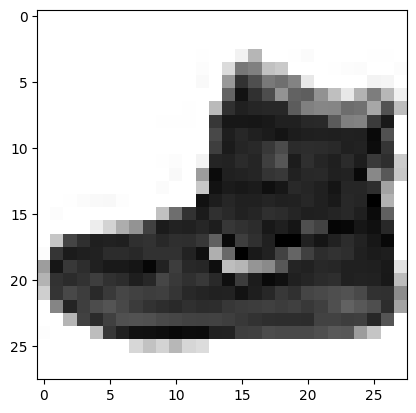

In [ ]:
img = xb[0][0]
plt.imshow(img)

Using show_image this is much simpler

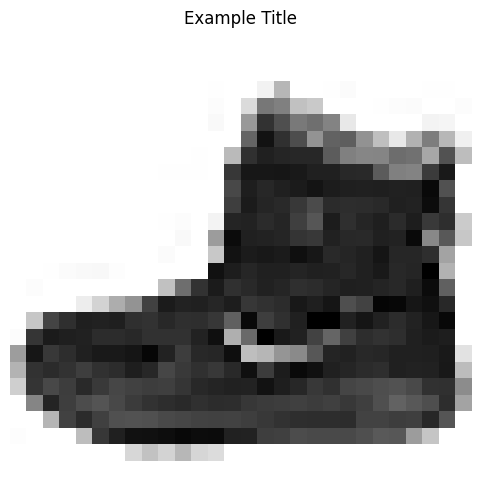

In [ ]:
show_image(xb[0], figsize=(6,6), title="Example Title");

### From single images with show_image showing multiple images

It is often necessary to plot multiple images in a grid.  To do so effectively it is necessary to size the imaged appropriated and to only show images where one exists (ie empty spots on the grid should reamin empty. ALso we need to make sure we can add labels to each image

In [ ]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int=1, # Number of rows
    ncols: int=1, # Number of columns
    figsize: tuple=None, #Size of overall figure that will be produced in default units
    imsize: float=3, # size of individual images in default units
    suptitle: str=None, # Title for the plot
    **kwargs
    ) -> (plt.Figure, plt.Axes):
    """ create grid of axes ready for assignment of images to each axis
        Args:
            nrows (int): number of rows
            ncols (int): number of columns
            figsize (Tuple[float, float]): Size of overall figure that will be produced in default units
            imsize (float): size of individual images in default units
            suptitle (Union[str, None]): title for the overall figure
    
        Returns:
            fig: plt.Figure
            ax: np.array(plt.Axes)
    """
    # calculate fig size if not supplied
    if figsize is None:
        figsize = (ncols*imsize, nrows*imsize)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)

    # If only one axes then turn into a array to allow consistent processing (multiple axes are stored as arrays)
    if ncols*nrows==1: ax=array([ax])
    return fig, ax 

The above function can then be used with multiple images as follows:

In [ ]:
lbls = [labels.int2str(int(y)) for y in yb[:8]]

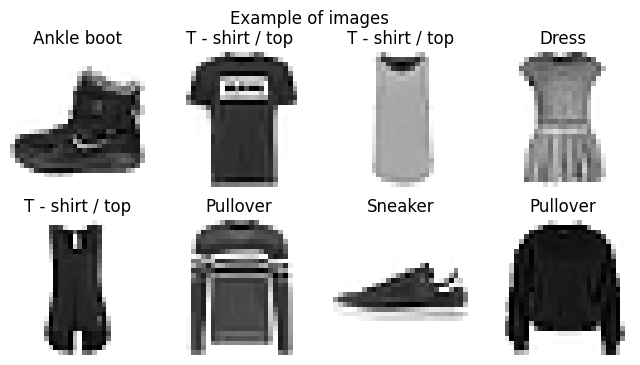

In [ ]:
fig, axs = subplots(nrows=2, ncols=4, imsize=2, suptitle="Example of images")
imgs = xb[:8]
lbls = [labels.int2str(int(y)) for y in yb[:8]]
for ax, img, lbl in zip(axs.flat, imgs, lbls): show_image(img, ax, title=lbl)

The function more intelligent by automatically calculating the size of the images and allowing the title to have weight and size defined.  This function can be built on top of the subplots method above

In [ ]:
#|export
@fc.delegates(subplots)
def get_grid(
    n: int, # Number of axes
    nrows: int=None, # Number of rows
    ncols: int=None, # Number of columns
    #title: str=None, # Plot title, optional
    weight: str='bold', # Weight to apply to the title
    size: int=14, # size of the title font
    **kwargs
    
):
    # "Return a grid of n axes over a combination of rows and columns."
    # If the rows are specified then ncols will be used if specified but if not then the columns needed
    # will be calculated.  Note that "or" will return the first value unless it is None, when it returns 
    # the second
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = int(np.ceil(n/ncols))
    else:
        nrows = int(np.ceil(math.sqrt(n)))
        ncols = int(np.ceil(n/nrows))
        
    # Avoid passing cmap to subplots
    _ = kwargs.pop('cmap', None)
    # Avoid passing suptitle to subplots
    if 'suptitle' in kwargs.keys():
        suptitle = kwargs.pop('suptitle', None)
    fig, axs = subplots(nrows, ncols, **kwargs)
    # Turn of the display of axis where there are no images (ie where there are unused positions on the grid)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    # Add the overall plot title if necessary
    if suptitle:
        fig.suptitle(suptitle, weight=weight, size=size)
    return fig, axs

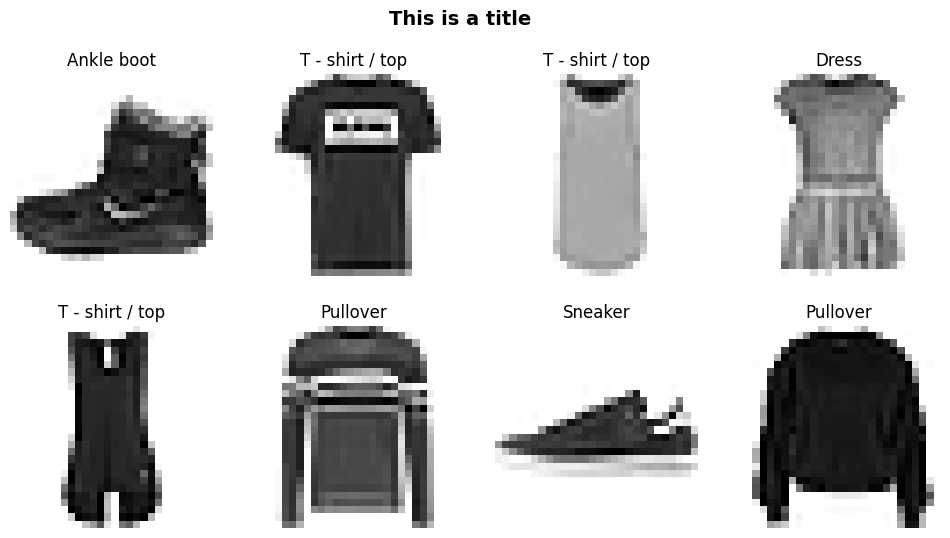

In [ ]:
fig, axs = get_grid(8, nrows=2, suptitle="This is a title")
for ax, img, lbl in zip(axs.flat, imgs, lbls): show_image(img, ax, title=lbl)

Finally it is possible to now create a show_images function that uses show image to display individual images and get_grid to provide the grid of axes upon which to plot them.  We will also pass in the labels for each object so that this can be used as a title for each image

In [ ]:
#|export
@fc.delegates(subplots)
def show_images(
    imgs: list, # List of images to show
    nrows: int=1, # Number of rows
    ncols: int=None, # Number of columns
    titles: List[str]=None, # list of individual sub-plot headings
    #suptitle: str=None, # Plot title, optional, list of titles for each image
    **kwargs
):
    # Create a grid of axes ready to plot the images
    axs = get_grid(len(imgs), **kwargs)[1].flat
    # Remove unwanted kwargs that are used by get_grid but not needed by show_image
    _ = kwargs.pop('imsize', None)
    _ = kwargs.pop('suptitle', None)
    # plot images and individual labels
    for img, t, ax in zip_longest(imgs, titles or [], axs[:len(imgs)]):
        show_image(img, ax, t, **kwargs)

In [ ]:
help(show_images)

Help on function show_images in module __main__:

show_images(imgs: 'list', nrows: 'int' = 1, ncols: 'int' = None, titles: 'List[str]' = None, *, figsize: 'tuple' = None, imsize: 'float' = 3, suptitle: 'str' = None, sharex=False, sharey=False, squeeze=True, width_ratios=None, height_ratios=None, subplot_kw=None, gridspec_kw=None)
    #|export



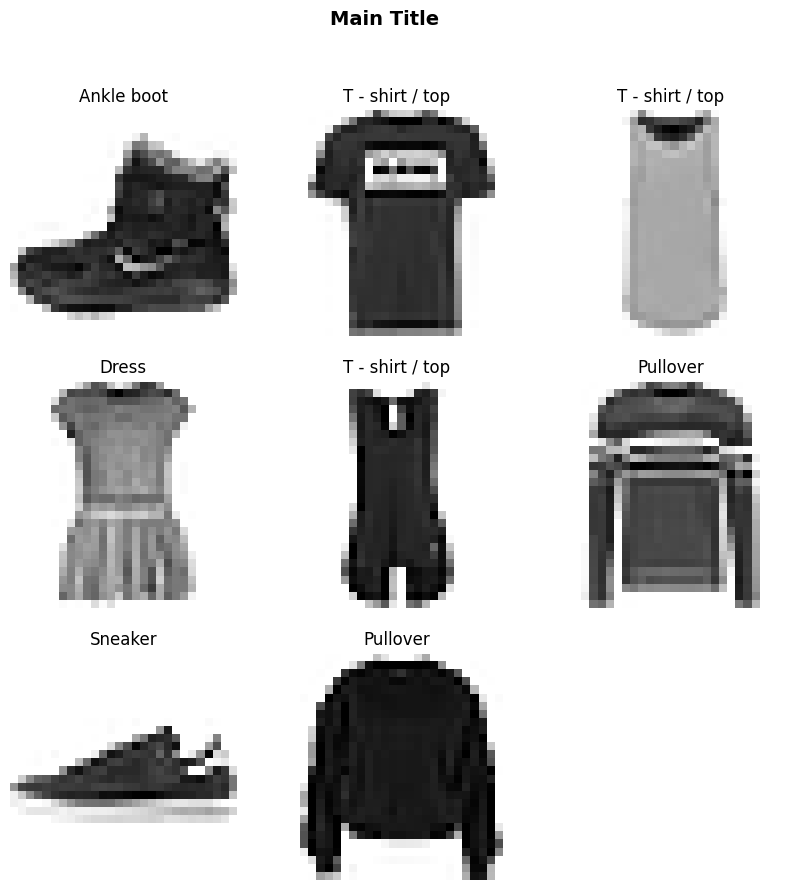

In [ ]:
show_images(imgs, suptitle="Main Title", titles=lbls, imsize=2.0, nrows=3, ncols=3, cmap="gray_r",
           figsize=(10,10))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()